In [1]:
# using LinearAlgebra
using SparseArrays
# using Random
using CairoMakie
# using Statistics
# using ProgressMeter
using DataFrames
using StatsBase
using DelimitedFiles

In [2]:
include("EchoStateNetworks.jl")
using .EchoStateNetworks
include("ONReservoir.jl")
using .ONReservoir
include("TurningError.jl")
using .TurningError
include("TestingFunctions.jl")
using .TestingFunctions

In [3]:
ts_str = ["x", "y", "z"];

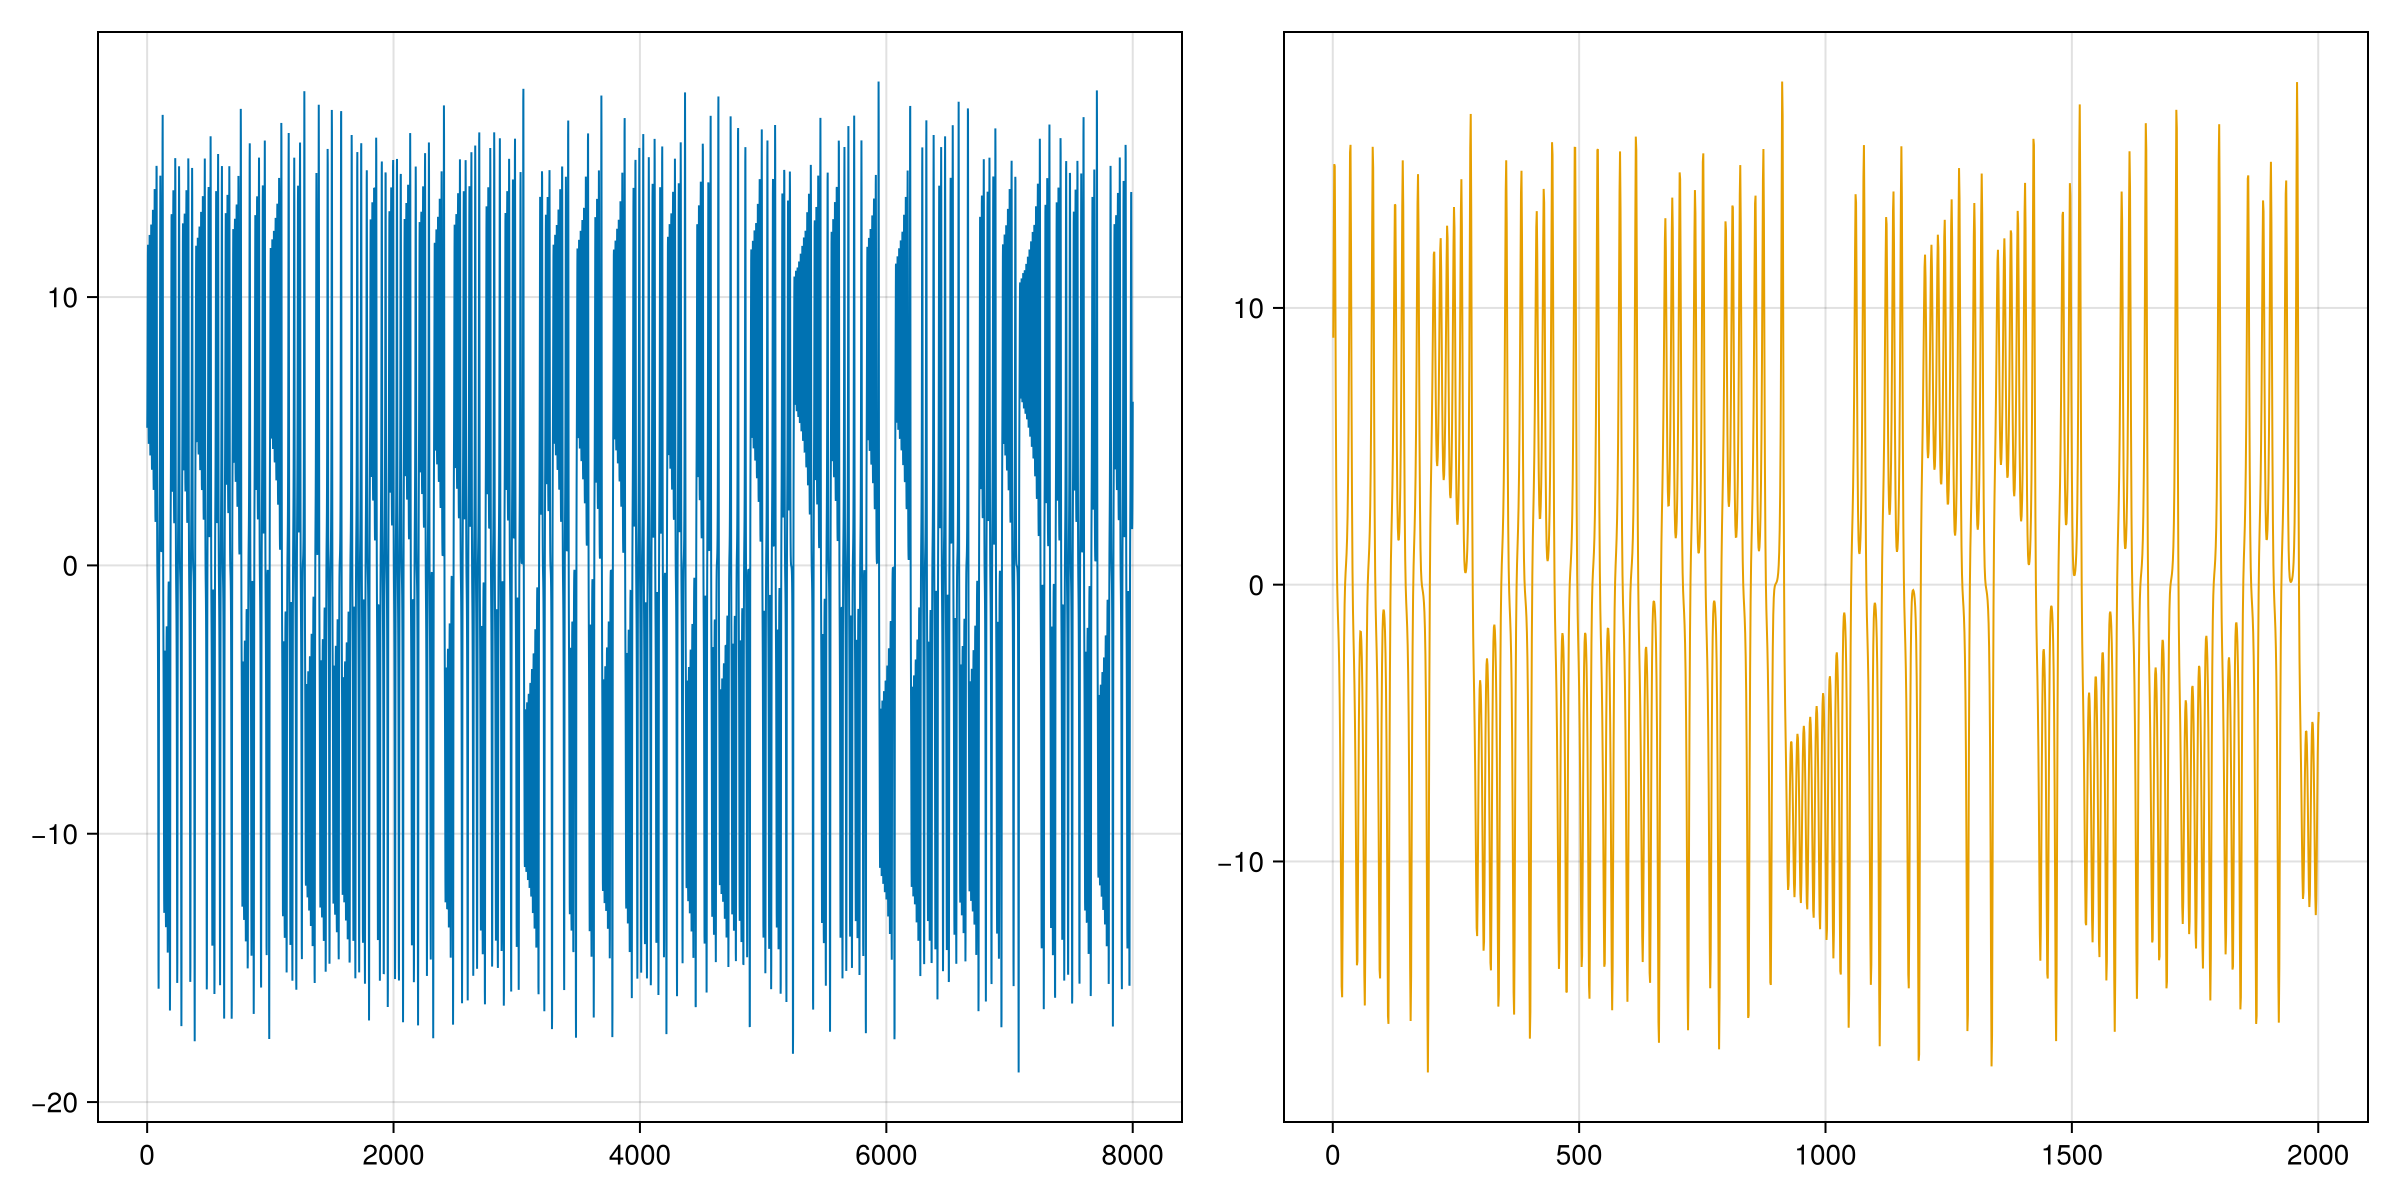

In [4]:
lo_train = vec(readdlm("lorenz_train.txt"))
lo_test = vec(readdlm("lorenz_test.txt"))

fig = Figure( size = (1200,600) )
lines!(Axis(fig[1,1]), lo_train; linewidth = 1.0, color = Cycled(1))
lines!(Axis(fig[1,2]), lo_test; linewidth = 1.0, color = Cycled(2))
fig

In [5]:
test_ON_part_adjacency = [
    0.7 0.1 0.2;
    0 0.7 0.3;
    0.4 0 0.6
]

k = 8
d = 3
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=3, ON_part_adjacency=test_ON_part_adjacency)

DataFrame(ESN_params.V_rec, :auto)

24×24 DataFrame
 Row │ x1        x2        x3        x4        x5        x6         x7         ⋯
     │ Float64   Float64   Float64   Float64   Float64   Float64    Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0       0.182054  0.0       0.0       0.0       0.525205   0.0        ⋯
   2 │ 0.182054  0.0       0.0       0.980772  0.0       0.0        0.0
   3 │ 0.0       0.0       0.0       0.181498  0.450043  0.593294   0.0
   4 │ 0.0       0.980772  0.181498  0.0       0.0       0.0        0.0
   5 │ 0.0       0.0       0.450043  0.0       0.0       0.0        0.375534   ⋯
   6 │ 0.525205  0.0       0.593294  0.0       0.0       0.0        0.0
   7 │ 0.0       0.0       0.0       0.0       0.375534  0.0        0.0
   8 │ 0.0       0.0       1.05556   0.0       0.0       0.0852653  0.0
  ⋮  │    ⋮         ⋮         ⋮         ⋮         ⋮          ⋮         ⋮       ⋱
  18 │ 0.0       0.619341  0.0       0.0       0.0       0.0        0.0        ⋯
  19 │ 0.0       0.0       0.619341  0.0       0.0       0.0        0.0
  20 │ 0.0       0.0       0.0       0.619341  0.0       0.0        0.0
  21 │ 0.0       0.0       0.0       0.0       0.619341  0.0        0.0
  22 │ 0.0       0.0       0.0       0.0       0.0       0.619341   0.0        ⋯
  23 │ 0.0       0.0       0.0       0.0       0.0       0.0        0.619341
  24 │ 0.0       0.0       0.0       0.0       0.0       0.0        0.0
                                                   17 columns and 9 rows omitted

In [7]:
m = 3
k = 4
part_connection=0.5
d = k*0.05
ρ = 1.2
α = 1.0
η = 1/maximum(lo_train)
β = 0.001
w = 1
τ = 2

window_size = (m-1)*τ
    
part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
num_partitions = length(unique_partitions_train)
# trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, ON_part_adjacency=trans_adjacency_matrix)

R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)


part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
preds, test_states = one_step_pred(lo_test, ESN_params, R, S = train_states[end,:], partition_symbols=part_symbols_test)

([0.0, 0.0, 0.0, 0.0, 13.968453787134962, 2.0021424207011194, 3.0279402073050505, 1.2778892228668894, -0.08065367683519753, -1.0909742857745073  …  -7.186085018378719, -10.770721914185913, -12.035345548102242, -12.713460638473975, -12.245412465157472, -6.532390922883565, -2.6367852729575816, -6.1110686226684265, -5.598894601350651, -5.8217642604904825], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.9736799739945805 0.07099286599320508 … -0.944605326562084 -0.987014250864701; -0.9736874562382314 0.06840034167427453 … -0.934773527657793 -0.9867383981550598])

In [8]:
trans_adjacency_matrix

6×6 Matrix{Float64}:
 0.865348   0.126675   0.00797703  0.0        0.0        0.0
 0.0        0.0340633  0.931873    0.0340633  0.0        0.0
 0.0        0.0        0.0577367   0.942263   0.0        0.0
 0.0        0.0        0.0         0.867003   0.127009   0.00598802
 0.0289157  0.0        0.0         0.0        0.0289157  0.942169
 0.955711   0.0        0.0         0.0        0.0        0.044289

In [9]:
DataFrame(ESN_params.V_rec, :auto)

24×24 DataFrame
 Row │ x1         x2         x3         x4         x5        x6        x7      ⋯
     │ Float64    Float64    Float64    Float64    Float64   Float64   Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0        0.0        0.0        0.0        0.303652  0.0       0.0     ⋯
   2 │ 0.0        0.0        0.0        0.0        0.0       0.303652  0.0
   3 │ 0.0        0.0        0.0        0.0        0.0       0.0       0.30365
   4 │ 0.0        0.0        0.0        0.0        0.0       0.0       0.0
   5 │ 0.0        0.0        0.0        0.0        0.0       0.0       0.0     ⋯
   6 │ 0.0        0.0        0.0        0.0        0.0       0.0       0.0
   7 │ 0.0        0.0        0.0        0.0        0.0       0.0       0.0
   8 │ 0.0        0.0        0.0        0.0        0.0       0.0       0.0
  ⋮  │     ⋮          ⋮          ⋮          ⋮         ⋮         ⋮         ⋮    ⋱
  18 │ 0.0        0.0693135  0.0        0.0        0.0       0.0       0.0     ⋯
  19 │ 0.0        0.0        0.0693135  0.0        0.0       0.0       0.0
  20 │ 0.0        0.0        0.0        0.0693135  0.0       0.0       0.0
  21 │ 2.29093    0.0        0.0        0.0        0.0       0.0       0.0
  22 │ 0.0        2.29093    0.0        0.0        0.0       0.0       0.0     ⋯
  23 │ 0.0        0.0        2.29093    0.0        0.0       0.0       0.0
  24 │ 0.0        0.0        0.0        2.29093    0.0       0.0       0.0
                                                   18 columns and 9 rows omitted

In [12]:
function RMSE(y_true, y_pred)
    return sqrt(mean((y_true .- y_pred) .^ 2))
end

RMSE (generic function with 1 method)

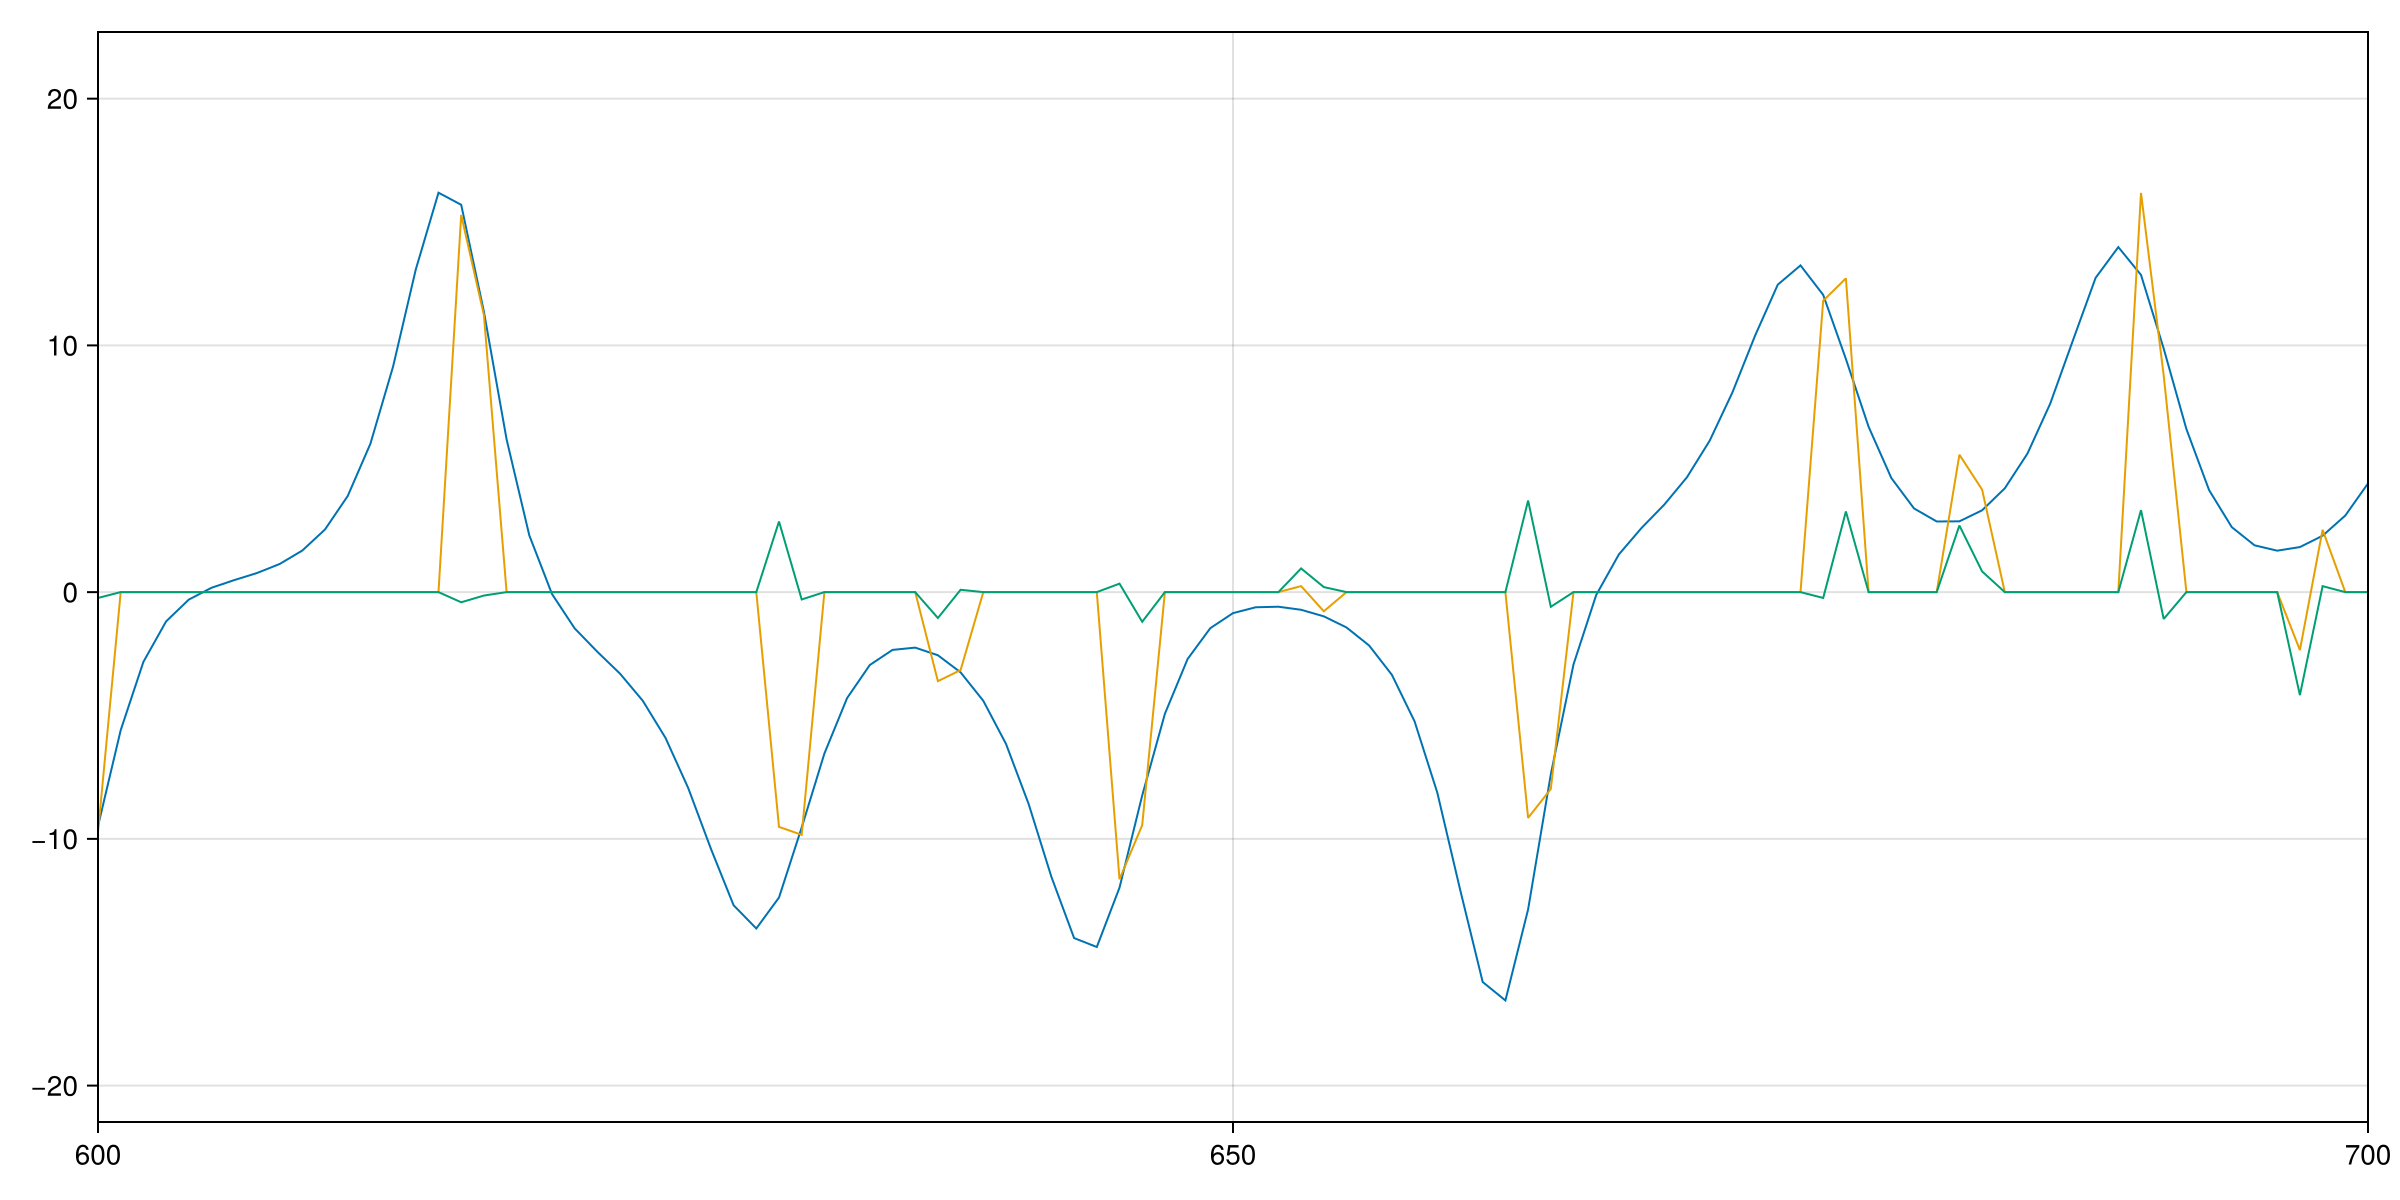

In [13]:
test_preds = lo_test + 3 * randn(length(lo_test))

test_mask = create_turning_partition_mask(lo_test, 4, 1, 1)
error = test_preds .- lo_test

fig = Figure( size = (1200,600))

ax1 = Axis(fig[1,1])
lines!(ax1, lo_test; linewidth = 1.0, color = Cycled(1))
lines!(ax1, test_preds .* test_mask; linewidth = 1.0, color = Cycled(2))
lines!(ax1, error .* test_mask; linewidth = 1.0, color = Cycled(3))

xlims!(600,700)

fig

## Single step predictions

### Equal size of overall reservoir

#### 600 total size

In [15]:
# good candidate for multithreading
ON_preds = create_pred_for_params_single_step(lo_train, lo_test, 3; k = 100, part_connection=0.5)
vanilla_preds = create_pred_for_params_single_step(lo_train, lo_test, 1; k = 600)
;

Created reservoir of size: (600,)
Created reservoir of size: (600,)


In [16]:
compare_preds(ON_preds, vanilla_preds, 200, 500, ignore_first=20)

MethodError: MethodError: no method matching compare_preds(::Vector{Float64}, ::Vector{Float64}, ::Int64, ::Int64; ignore_first::Int64)

Closest candidates are:
  compare_preds(::Any, ::Any, ::Any, ::Any, !Matched::Any; calculate_error, ignore_first, offset)
   @ Main.TestingFunctions ~/Desktop/Uni/Honours Research/echo-state-networks/TestingFunctions.jl:13


#### 60 overall size

In [19]:
ON_preds = create_pred_for_params_single_step(3; k = 10, d=2, part_connection=0.5)
vanilla_preds = create_pred_for_params_single_step(1; k = 60)
;

MethodError: MethodError: no method matching create_pred_for_params_single_step(::Int64; k::Int64, d::Int64, part_connection::Float64)

Closest candidates are:
  create_pred_for_params_single_step(::Any, !Matched::Any, !Matched::Any; k, part_connection, d, ρ, α, η, β, w, τ)
   @ Main.TestingFunctions ~/Desktop/Uni/Honours Research/echo-state-networks/TestingFunctions.jl:57


In [20]:
compare_preds(ON_preds, vanilla_preds, nothing, nothing, ignore_first=20)

MethodError: MethodError: no method matching compare_preds(::Vector{Float64}, ::Vector{Float64}, ::Nothing, ::Nothing; ignore_first::Int64)

Closest candidates are:
  compare_preds(::Any, ::Any, ::Any, ::Any, !Matched::Any; calculate_error, ignore_first, offset)
   @ Main.TestingFunctions ~/Desktop/Uni/Honours Research/echo-state-networks/TestingFunctions.jl:13


In [23]:
ON_preds = create_pred_for_params_single_step(3; k = 50, part_connection=0.5)
vanilla_preds = create_pred_for_params_single_step(1; k = 300)
;

MethodError: MethodError: no method matching create_pred_for_params_single_step(::Int64; k::Int64, part_connection::Float64)

Closest candidates are:
  create_pred_for_params_single_step(::Any, !Matched::Any, !Matched::Any; k, part_connection, d, ρ, α, η, β, w, τ)
   @ Main.TestingFunctions ~/Desktop/Uni/Honours Research/echo-state-networks/TestingFunctions.jl:57


In [24]:
compare_preds(ON_preds, vanilla_preds, nothing, nothing, ignore_first=20)

MethodError: MethodError: no method matching compare_preds(::Vector{Float64}, ::Vector{Float64}, ::Nothing, ::Nothing; ignore_first::Int64)

Closest candidates are:
  compare_preds(::Any, ::Any, ::Any, ::Any, !Matched::Any; calculate_error, ignore_first, offset)
   @ Main.TestingFunctions ~/Desktop/Uni/Honours Research/echo-state-networks/TestingFunctions.jl:13


In [26]:
ON_preds = create_pred_for_params_single_step(3; k = 200, d=2, part_connection=0.5)
vanilla_preds = create_pred_for_params_single_step(1; k = 1200)
;

MethodError: MethodError: no method matching create_pred_for_params_single_step(::Int64; k::Int64, d::Int64, part_connection::Float64)

Closest candidates are:
  create_pred_for_params_single_step(::Any, !Matched::Any, !Matched::Any; k, part_connection, d, ρ, α, η, β, w, τ)
   @ Main.TestingFunctions ~/Desktop/Uni/Honours Research/echo-state-networks/TestingFunctions.jl:57


In [27]:
compare_preds(ON_preds, vanilla_preds, nothing, nothing, ignore_first=20)

MethodError: MethodError: no method matching compare_preds(::Vector{Float64}, ::Vector{Float64}, ::Nothing, ::Nothing; ignore_first::Int64)

Closest candidates are:
  compare_preds(::Any, ::Any, ::Any, ::Any, !Matched::Any; calculate_error, ignore_first, offset)
   @ Main.TestingFunctions ~/Desktop/Uni/Honours Research/echo-state-networks/TestingFunctions.jl:13


### Equal k

#### k = 100

In [29]:
# good candidate for multithreading
ON_preds = create_pred_for_params_single_step(3; k = 100, part_connection=0.5)
vanilla_preds = create_pred_for_params_single_step(1; k = 100)
;

MethodError: MethodError: no method matching create_pred_for_params_single_step(::Int64; k::Int64, part_connection::Float64)

Closest candidates are:
  create_pred_for_params_single_step(::Any, !Matched::Any, !Matched::Any; k, part_connection, d, ρ, α, η, β, w, τ)
   @ Main.TestingFunctions ~/Desktop/Uni/Honours Research/echo-state-networks/TestingFunctions.jl:57


In [30]:
compare_preds(ON_preds, vanilla_preds, 500, 600, ignore_first=20)

MethodError: MethodError: no method matching compare_preds(::Vector{Float64}, ::Vector{Float64}, ::Int64, ::Int64; ignore_first::Int64)

Closest candidates are:
  compare_preds(::Any, ::Any, ::Any, ::Any, !Matched::Any; calculate_error, ignore_first, offset)
   @ Main.TestingFunctions ~/Desktop/Uni/Honours Research/echo-state-networks/TestingFunctions.jl:13


#### k = 10

In [31]:
# good candidate for multithreading
ON_preds = create_pred_for_params_single_step(3; k = 10, part_connection=0.5)
vanilla_preds = create_pred_for_params_single_step(1; k = 10)
;

MethodError: MethodError: no method matching create_pred_for_params_single_step(::Int64; k::Int64, part_connection::Float64)

Closest candidates are:
  create_pred_for_params_single_step(::Any, !Matched::Any, !Matched::Any; k, part_connection, d, ρ, α, η, β, w, τ)
   @ Main.TestingFunctions ~/Desktop/Uni/Honours Research/echo-state-networks/TestingFunctions.jl:57


In [32]:
compare_preds(ON_preds, vanilla_preds, 500, 600, ignore_first=20)

MethodError: MethodError: no method matching compare_preds(::Vector{Float64}, ::Vector{Float64}, ::Int64, ::Int64; ignore_first::Int64)

Closest candidates are:
  compare_preds(::Any, ::Any, ::Any, ::Any, !Matched::Any; calculate_error, ignore_first, offset)
   @ Main.TestingFunctions ~/Desktop/Uni/Honours Research/echo-state-networks/TestingFunctions.jl:13


#### k = 500

In [33]:
# good candidate for multithreading
ON_preds = create_pred_for_params_single_step(3; k = 500, part_connection=0.5)
vanilla_preds = create_pred_for_params_single_step(1; k = 500)
;

MethodError: MethodError: no method matching create_pred_for_params_single_step(::Int64; k::Int64, part_connection::Float64)

Closest candidates are:
  create_pred_for_params_single_step(::Any, !Matched::Any, !Matched::Any; k, part_connection, d, ρ, α, η, β, w, τ)
   @ Main.TestingFunctions ~/Desktop/Uni/Honours Research/echo-state-networks/TestingFunctions.jl:57


In [34]:
compare_preds(ON_preds, vanilla_preds, 500, 600, ignore_first=20)

MethodError: MethodError: no method matching compare_preds(::Vector{Float64}, ::Vector{Float64}, ::Int64, ::Int64; ignore_first::Int64)

Closest candidates are:
  compare_preds(::Any, ::Any, ::Any, ::Any, !Matched::Any; calculate_error, ignore_first, offset)
   @ Main.TestingFunctions ~/Desktop/Uni/Honours Research/echo-state-networks/TestingFunctions.jl:13


## Freerun predictions

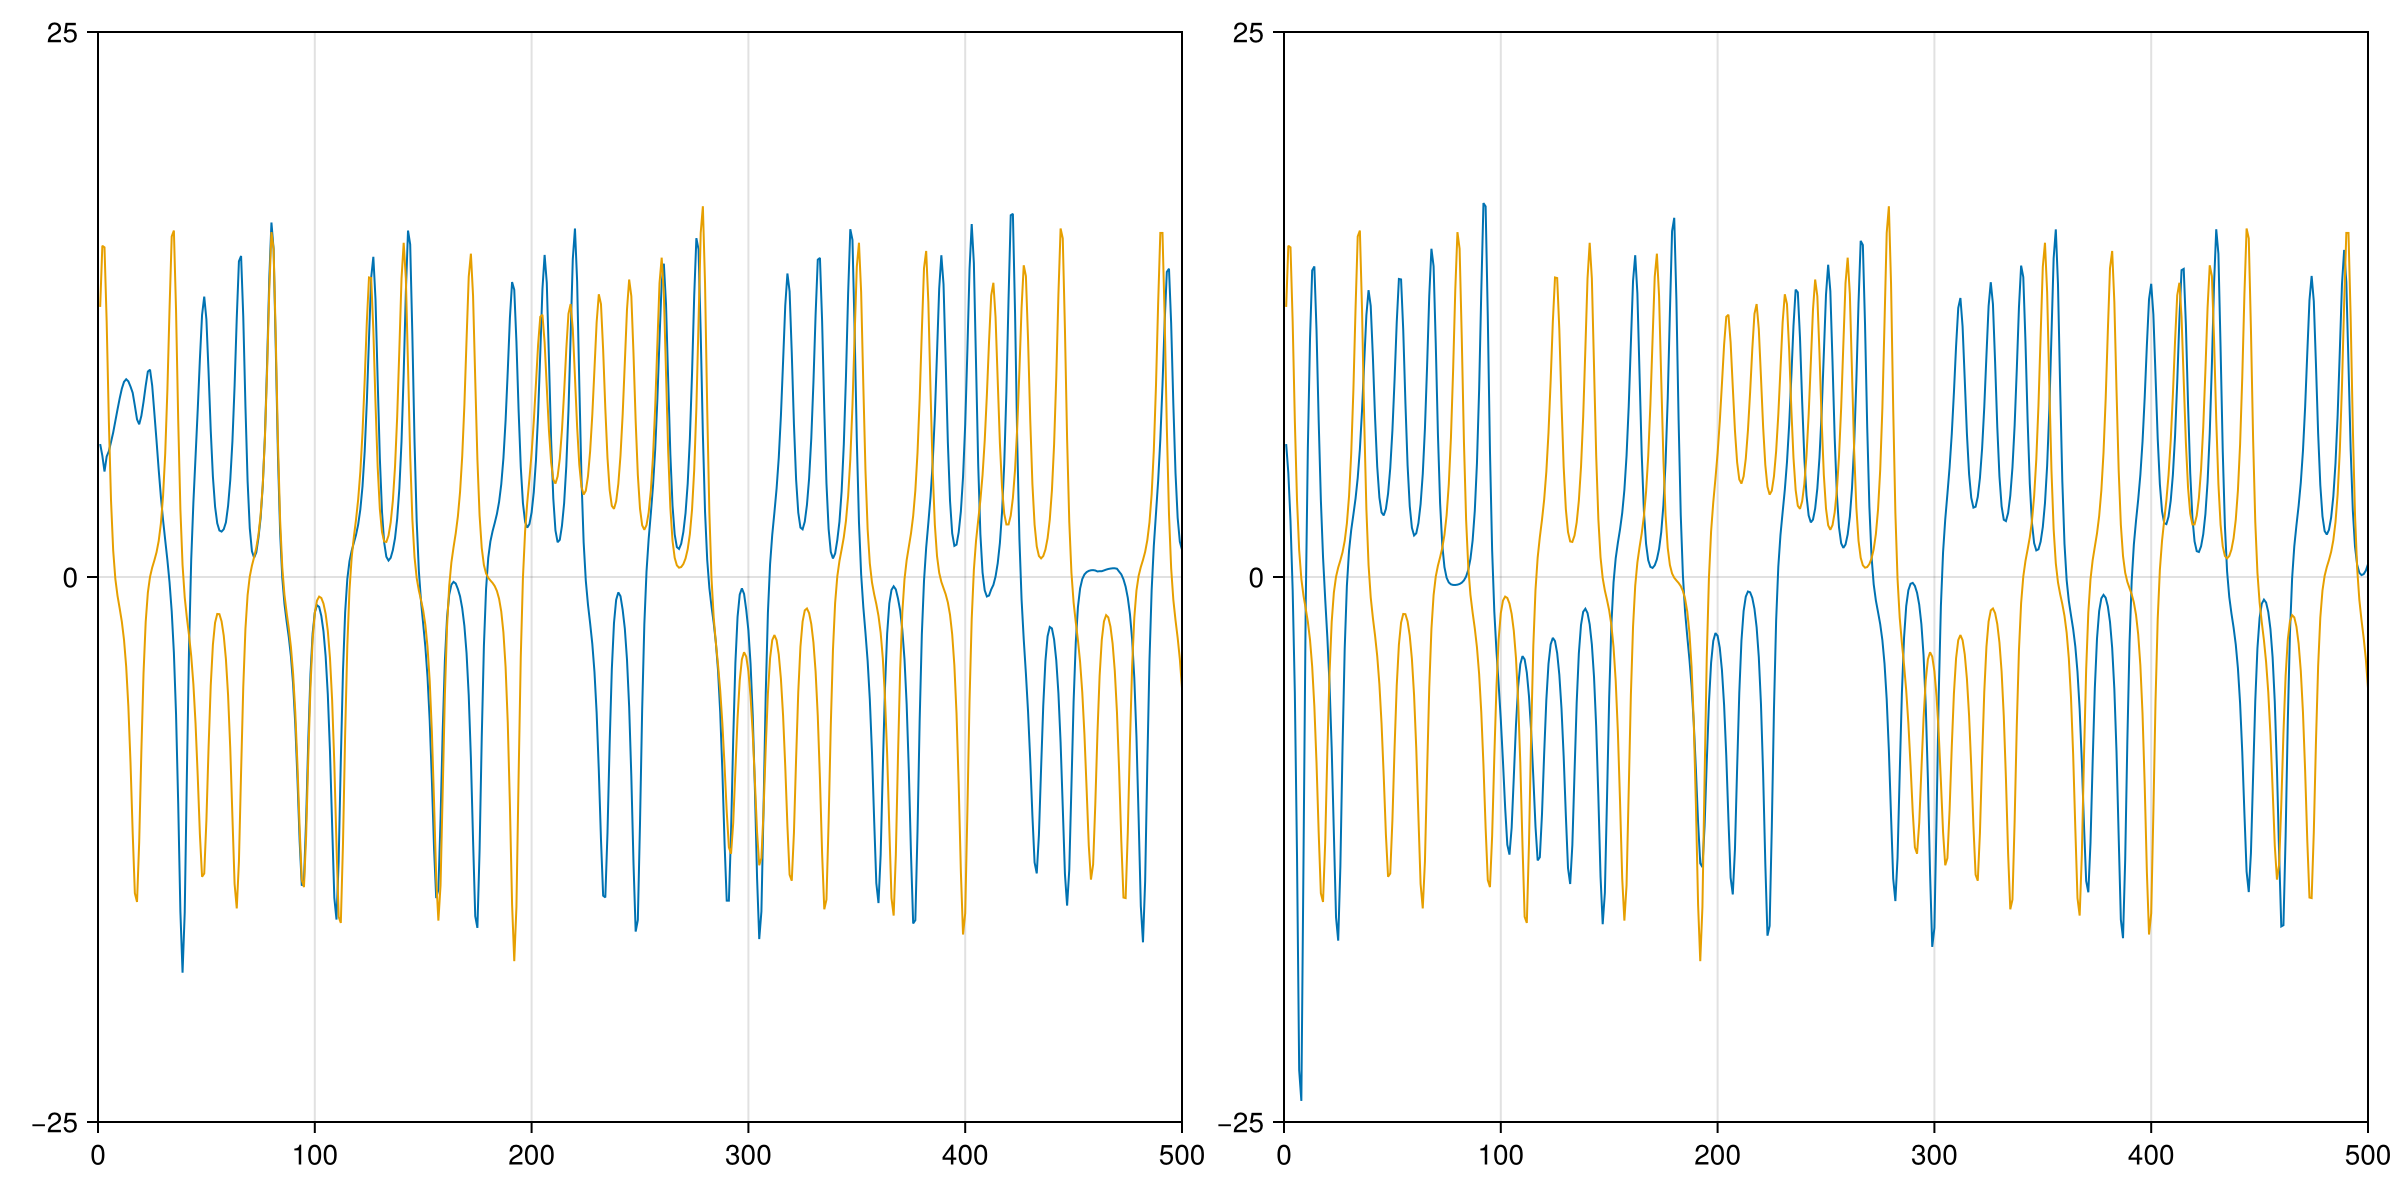

In [36]:
ON_preds_freerun = create_pred_for_params_free_run(lo_train, length(lo_test), 4; k = 100)
vanilla_preds_freerun = create_pred_for_params_free_run(lo_train, length(lo_test), 1; k = 400)

compare_preds(lo_test, ON_preds_freerun, vanilla_preds_freerun, 0, 500, calculate_error=false)

## Multi step predictions

In [25]:
ON_preds_multistep = create_pred_for_params_multi_step(3, 2; k = 400)
vanilla_preds_multistep = create_pred_for_params_multi_step(1, 2; k = 1200);

Ordinal network reservoir prediction RMSE: 1.6426654609401354
Vanilla prediction RMSE: 0.9291371833606827
Ordinal network reservoir prediction turning partition RMSE: 4.68094319371205
Vanilla prediction turning partition RMSE: 3.112945394665287


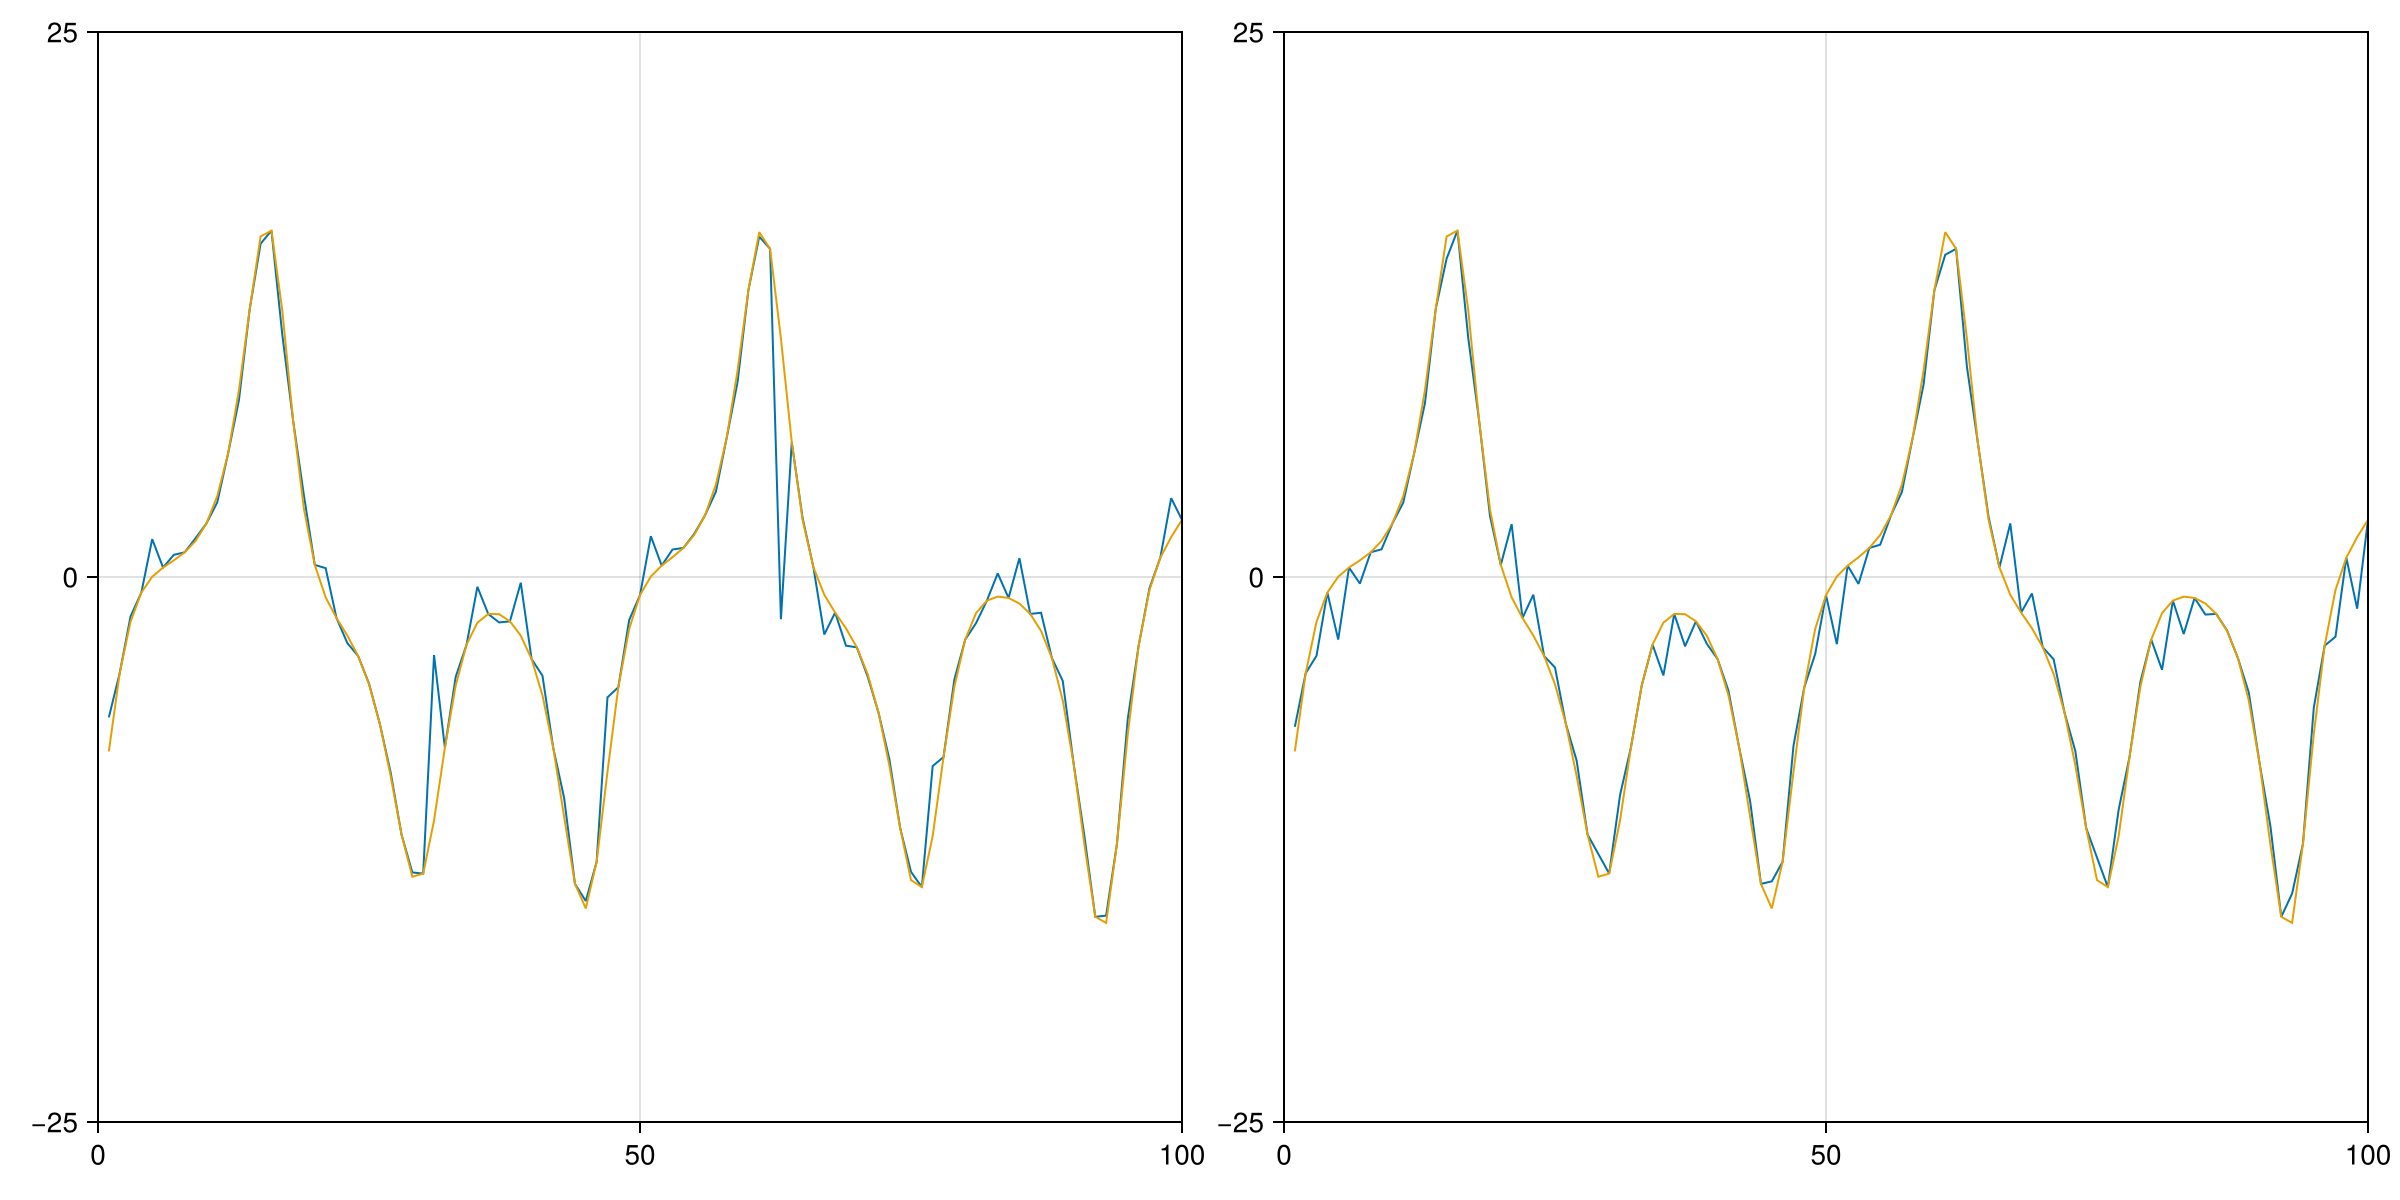

In [26]:
compare_preds(ON_preds_multistep, vanilla_preds_multistep, 0, 100, ignore_first=20, offset=0)

In [27]:
ON_preds_multistep = create_pred_for_params_multi_step(3, 3; k = 400)
vanilla_preds_multistep = create_pred_for_params_multi_step(1, 3; k = 1200);

Ordinal network reservoir prediction RMSE: 6.937057480243788
Vanilla prediction RMSE: 5.710465702125283
Ordinal network reservoir prediction turning partition RMSE: 14.776209501804008
Vanilla prediction turning partition RMSE: 5.754687399326348


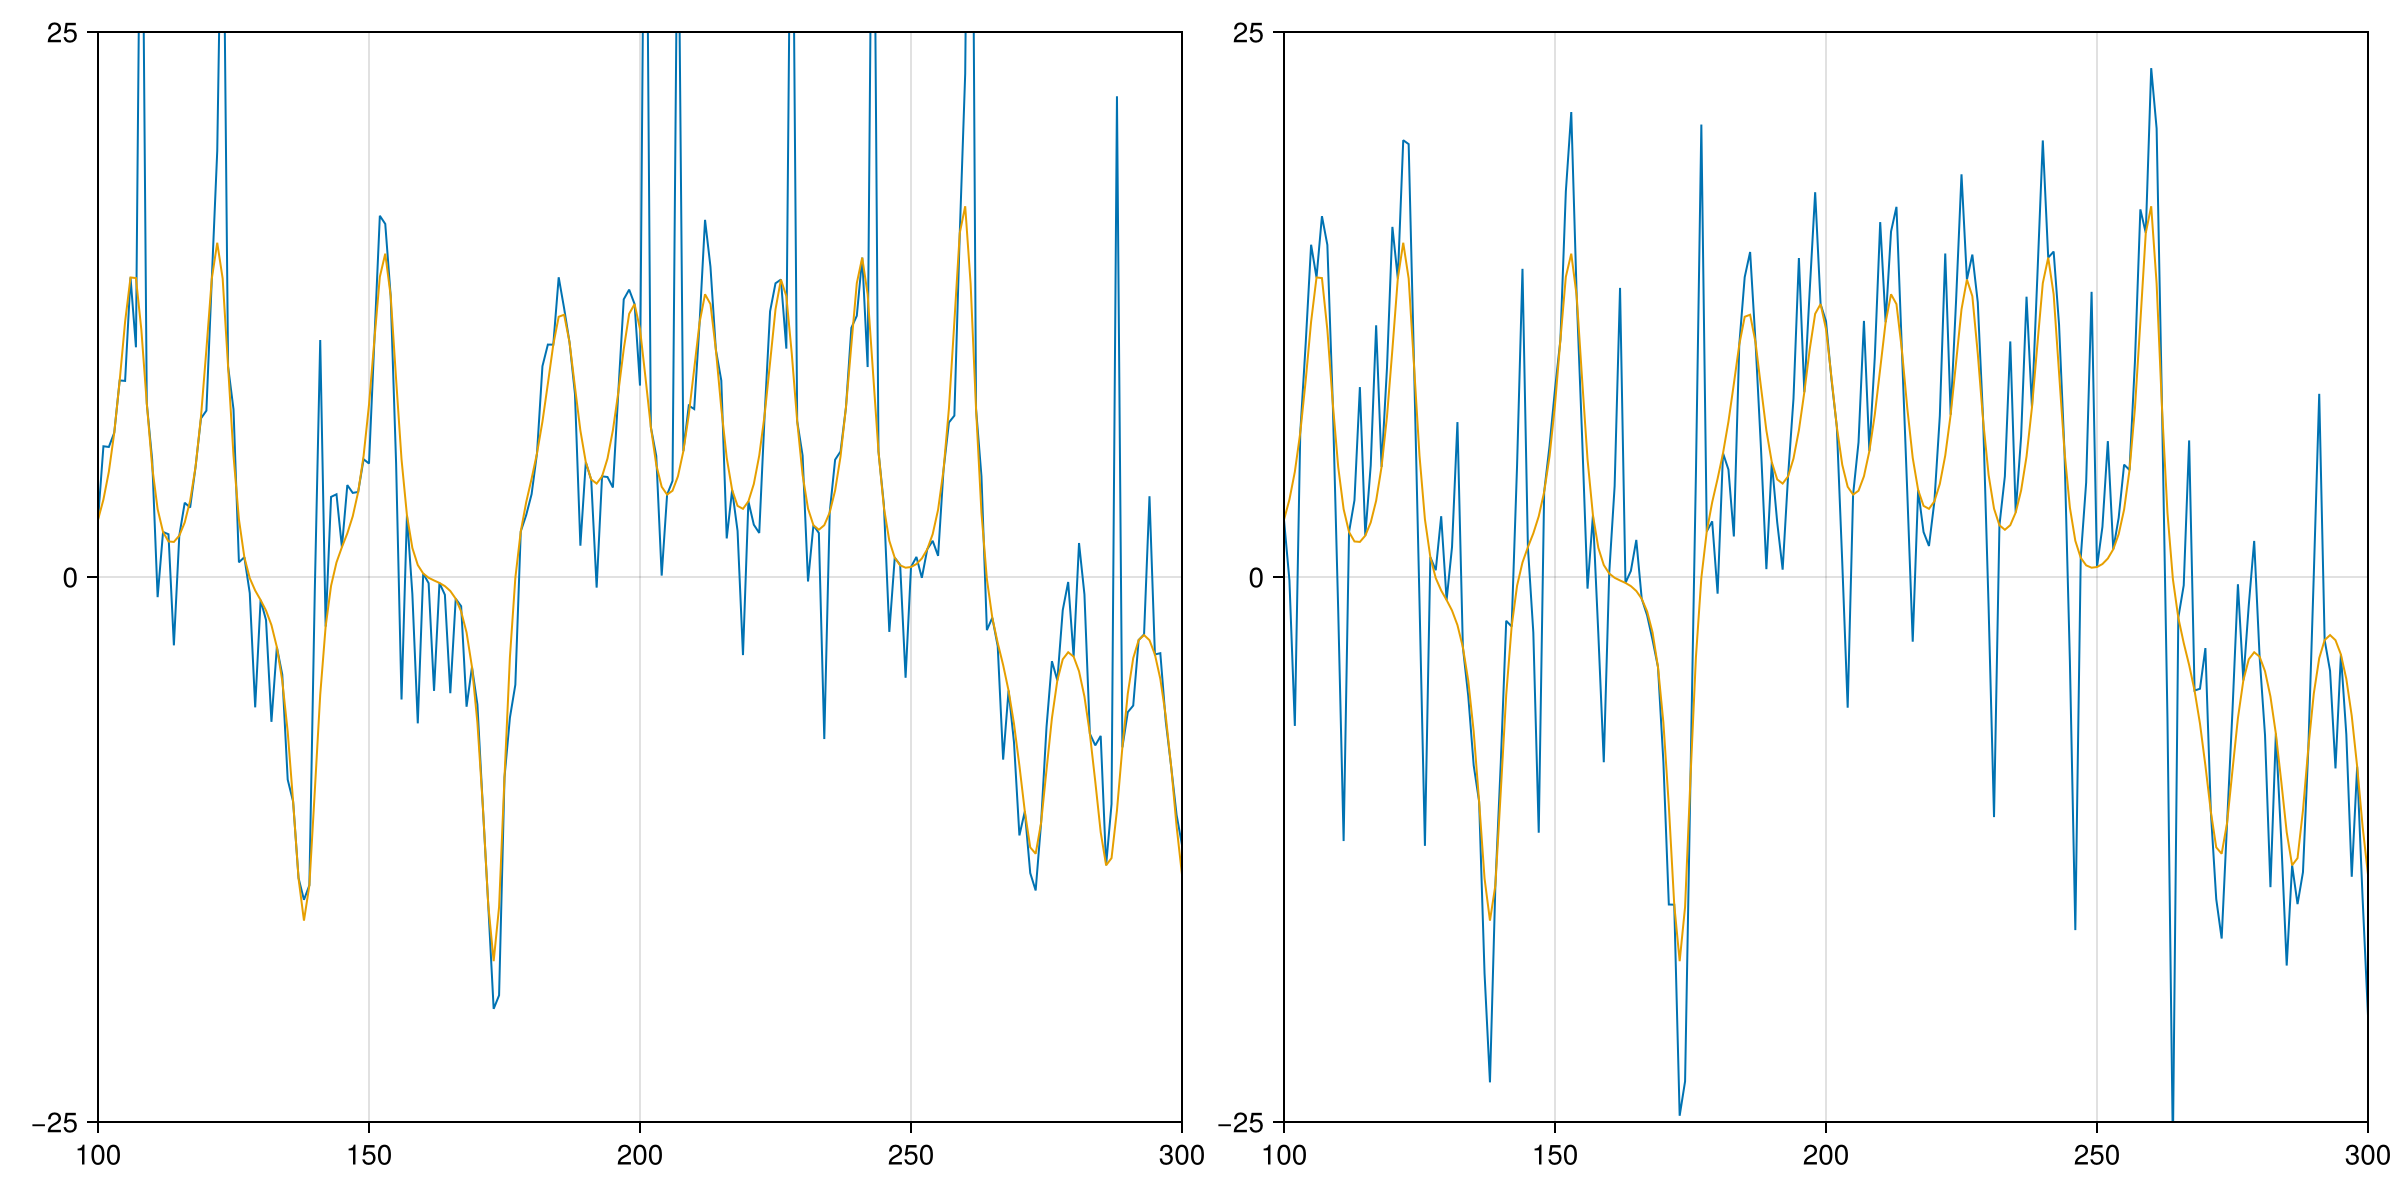

In [28]:
compare_preds(ON_preds_multistep, vanilla_preds_multistep, 100, 300, ignore_first=20, offset=0)

In [29]:
ON_preds_multistep = create_pred_for_params_multi_step(3, 4; k = 400)
vanilla_preds_multistep = create_pred_for_params_multi_step(1, 4; k = 1200);

Ordinal network reservoir prediction RMSE: 21.526147063268912
Vanilla prediction RMSE: 14.484932783313983
Ordinal network reservoir prediction turning partition RMSE: 46.70053178689948
Vanilla prediction turning partition RMSE: 10.712847101815347


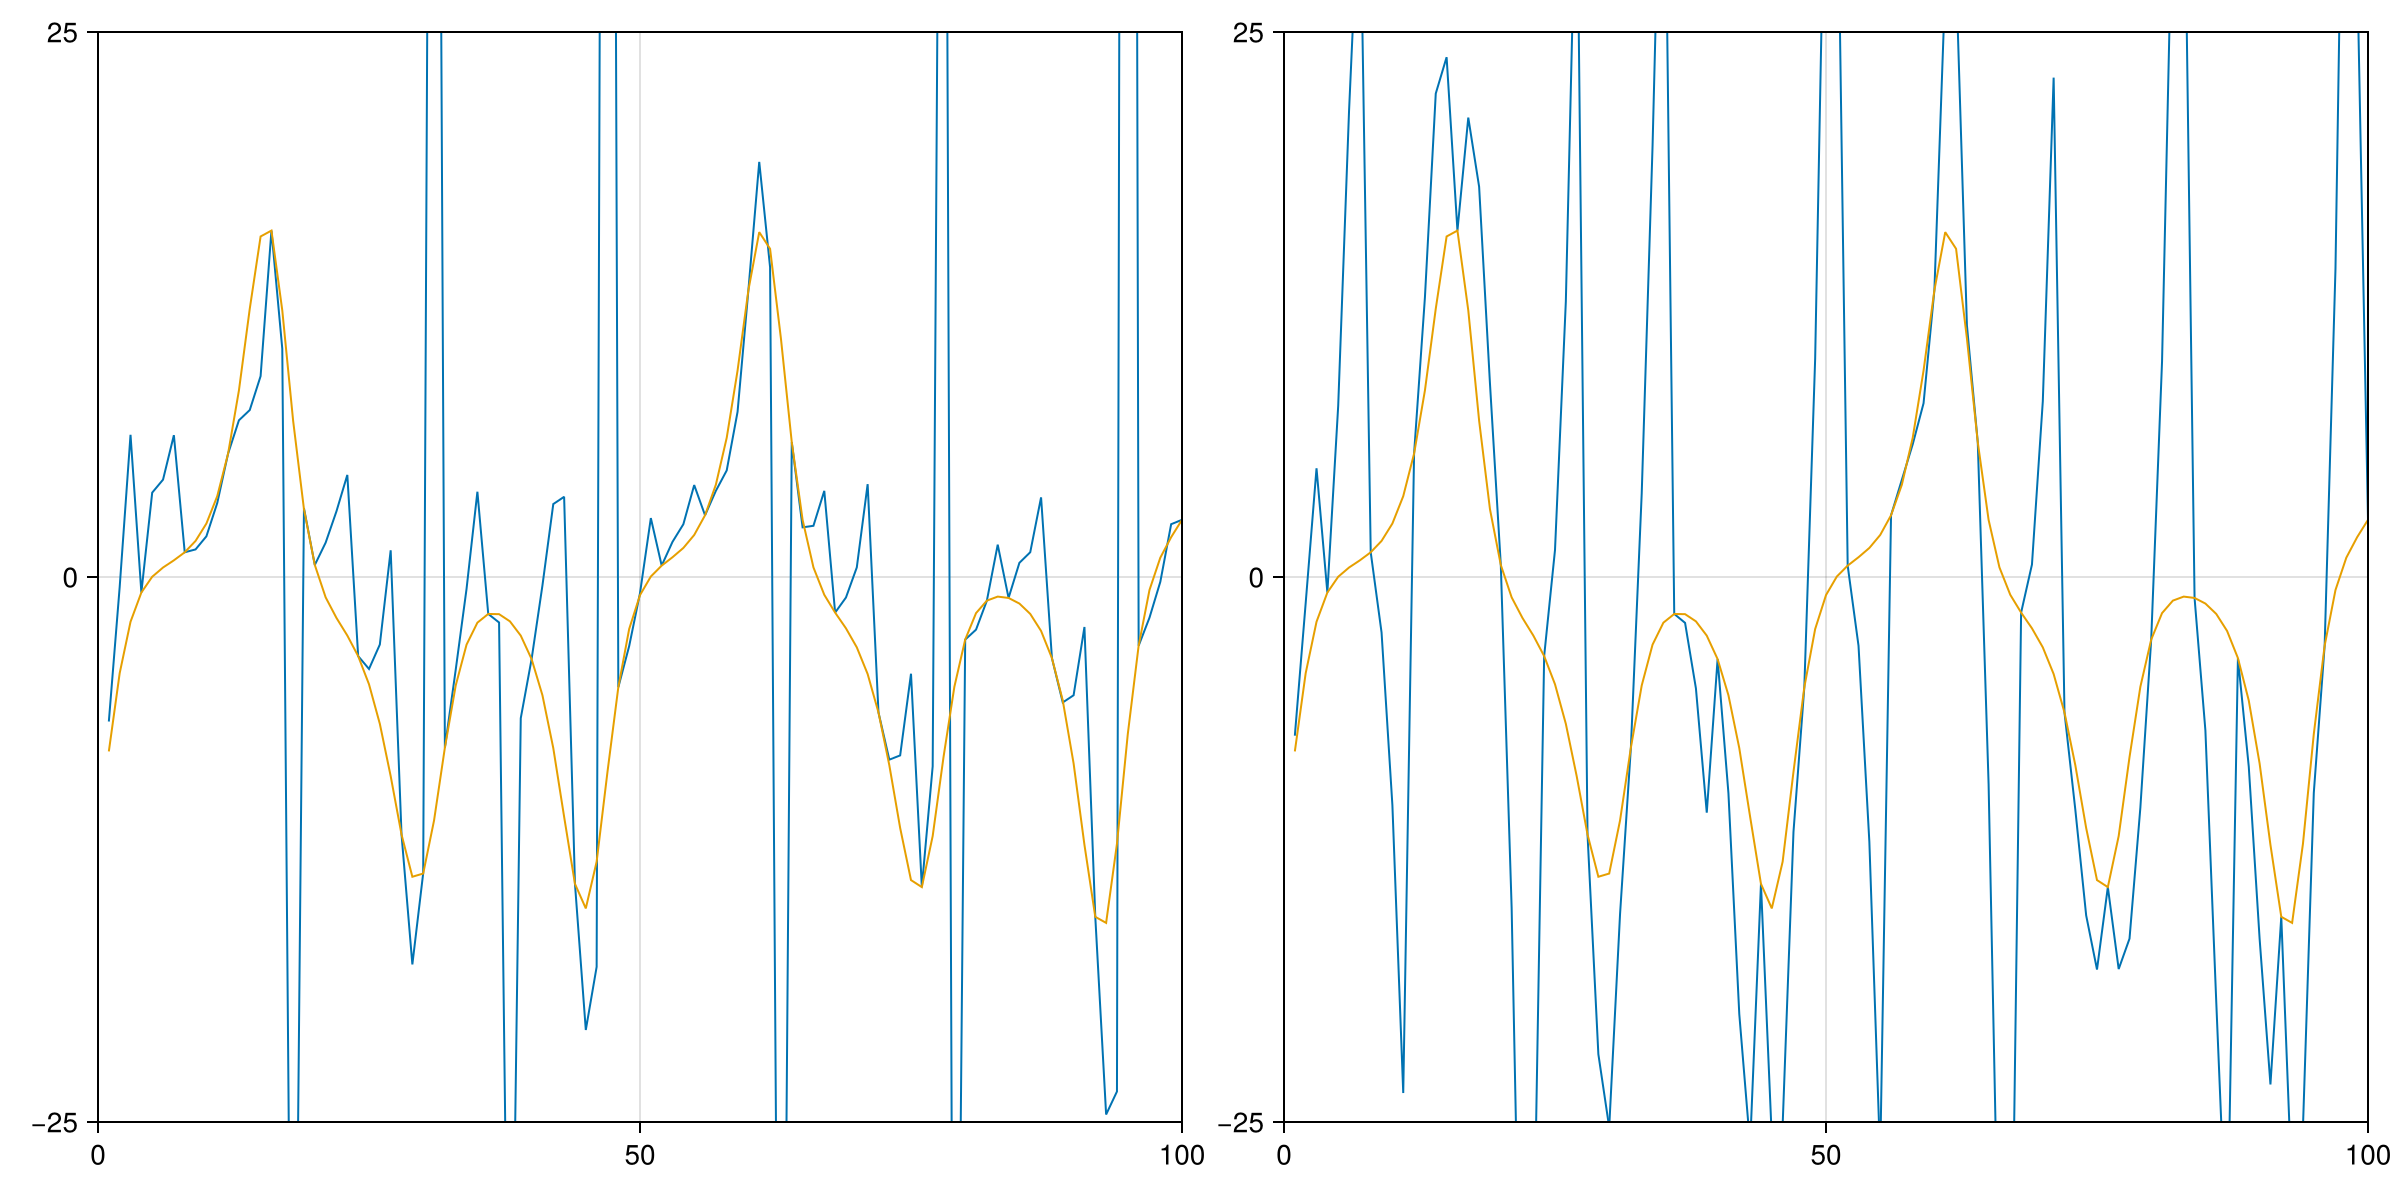

In [30]:
# compare_preds(ON_preds_multistep, vanilla_preds_multistep, 100, 300, ignore_first=20, offset=0)
compare_preds(ON_preds_multistep, vanilla_preds_multistep, 0, 100, ignore_first=20, offset=0)

In [31]:
test_part = create_ordinal_partition(lo_train, 4, 1, 1)
ON_trans_probs = find_probs(test_part)

UndefVarError: UndefVarError: `find_probs` not defined

In [38]:
# if we want it to train better, then we should mask the states before the output rather than mask the readout vector

test_k = 3
test_parts = 3

states = ones(test_k*test_parts, test_k*test_parts)

part = 2

n1 = (part-1)*test_k+1
n2 = part*test_k

states[:,1:n1-1] .= 0
states[:,n2+1:end] .= 0
states[1:n1-1,:] .= 0 
states[n2+1:end,:] .= 0

states

9×9 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [21]:
stts[:,1]

8000-element Vector{Float64}:
  0.0
  0.0
  0.0
 -0.8855873768015823
 -0.8918694465853841
 -0.8945142606516204
 -0.8953824844888286
 -0.8644381421355106
 -0.8693768768236068
 -0.8644645216479642
  ⋮
 -0.8644468447313552
 -0.864444062505199
 -0.8644453447646411
 -0.8644445291123618
 -0.8644439682373585
 -0.8644437595177974
 -0.8724980386251802
 -0.8759914136443797
 -0.8811643796292388

In [43]:
function test_mask_states!(states, partition_symbols, k, num_partitions)
    for part_i in 1:num_partitions
        states[(part_i-1)*k+1:part_i*k, partition_symbols[part_i]] .= 0
    end
end

state = ones(test_k*test_parts, test_k*test_parts)
states = [state, state, state]

# mask_states!(states, [1,2,3], test_k, test_parts)
states[][1:2,1] .= 0

states[1]

MethodError: MethodError: Cannot `convert` an object of type Int64 to an object of type Matrix{Float64}

Closest candidates are:
  convert(::Type{Array{T, N}}, !Matched::StaticArraysCore.SizedArray{S, T, N, N, Array{T, N}}) where {S, T, N}
   @ StaticArrays ~/.julia/packages/StaticArrays/MSJcA/src/SizedArray.jl:88
  convert(::Type{Array{T, N}}, !Matched::StaticArraysCore.SizedArray{S, T, N, M, TData} where {M, TData<:AbstractArray{T, M}}) where {T, S, N}
   @ StaticArrays ~/.julia/packages/StaticArrays/MSJcA/src/SizedArray.jl:82
  convert(::Type{Array{S, N}}, !Matched::PooledArrays.PooledArray{T, R, N}) where {S, T, R, N}
   @ PooledArrays ~/.julia/packages/PooledArrays/Vy2X0/src/PooledArrays.jl:499
  ...
